In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider, Dropdown
import ipywidgets as widgets
from exp_analysis import *

In [3]:
from Likelihood import LEff
import emcee

In [4]:
n_evt = 1000000
df_base = pd.read_pickle(f'/home/nic/Desktop/Dark_coherent/nicgen/data/nd280_nu/3plus1/scan/light_mediator/0.1_m4_0.5_0.01_mzprime_0.08_nevt_{n_evt}.pckl')
initialise_df(df_base, ctaus=[25], is_scan='m4_mz')

In [36]:
!mkdir -p ../../fig/kde_test_2d/mcmc_2d/
save_folder = "../../fig/kde_test_2d/mcmc_2d/"

In [5]:
def m4_mz_posterior(parameters, observed_events, df_base, ctau, smooth_m4, smooth_mz, selection_step):
    if (parameters[0] < 0.2) or (parameters[0] > 0.4) or (parameters[1] < 0.03) or (parameters[1] > 0.06):
        return -np.inf
    else:
        mu_kde, sigma2_kde = mu_sigma2_of_theta(df_base, parameters[0], parameters[1], ctau, smooth_m4, smooth_mz, selection_step)
        return LEff(observed_events, mu_kde, sigma2_kde)

In [20]:
smooth_m4 = 0.03
smooth_mz = 0.005
ctau = 10
selection_step = 'cut_based'
observed_events = 0

In [37]:
nwalkers = 4
ndim = 2
nstep = 100
m4_0 = np.random.uniform(0.2, 0.4, nwalkers)
mz_0 = np.random.uniform(0.03, 0.06, nwalkers)
p0 = np.stack([m4_0, mz_0], axis=-1)

In [42]:
%timeit m4_mz_posterior(p0[3], observed_events, df_base, ctau, smooth_m4, smooth_mz, selection_step)

724 ms ± 29.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [44]:
%timeit mu_kde, sigma2_kde = mu_sigma2_of_theta(df_base, p0[3,0], p0[3,1], ctau, smooth_m4, smooth_mz, selection_step)

656 ms ± 8.02 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [45]:
%timeit LEff(observed_events, mu_kde, sigma2_kde)

35.1 µs ± 836 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [24]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, m4_mz_posterior, args=[observed_events, df_base, ctau, smooth_m4, smooth_mz, selection_step])

In [25]:
state = sampler.run_mcmc(p0, 10, progress=True)

100%|██████████| 10/10 [00:19<00:00,  1.96s/it]


In [26]:
sampler.reset()

In [27]:
sampler.run_mcmc(state, nstep, progress=True)

100%|██████████| 100/100 [03:41<00:00,  2.21s/it]


State([[0.37866176 0.05802339]
 [0.35931787 0.05932231]
 [0.38400246 0.05599136]
 [0.38121581 0.05987393]], log_prob=[-43.78069237 -46.60782839 -44.78012674 -41.87643628], blobs=None, random_state=('MT19937', array([2151844498, 4270865865, 2348130384, 3831545443,  278378880,
       2997524451, 3432376212, 1803604345, 2133731085,  522645263,
       1630200151, 3704514380, 2747607252, 3009527085,  277790165,
       2382427646, 1468440932, 2327261424,  424973009, 1760991721,
        484549927, 3096022199, 2792668692, 3777053055, 2079840136,
        377015423, 3106526214,  892792491, 2529658999, 2236903487,
          6152385, 3834421721, 2137512630, 2016164227, 2067205582,
       2992828083,  101433782, 3686189372, 1519910663, 1717494510,
        855702147, 1155610912, 3722040425,  547760621, 3611115464,
       3208666187, 3115769409, 2415131525, 1905182415, 3431572392,
        565042700, 3237720514, 1396176680, 1945843747,  271599314,
       2927037313, 3090036296, 1765746879, 2302814769,

In [28]:
samples = sampler.get_chain(flat=True)

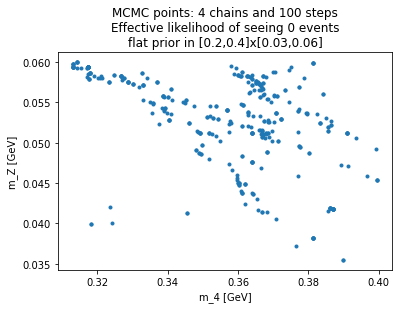

In [40]:
plt.plot(samples[:,0], samples[:,1], '.')
plt.title('MCMC points: 4 chains and 100 steps\nEffective likelihood of seeing 0 events\nflat prior in [0.2,0.4]x[0.03,0.06]')
plt.xlabel('m_4 [GeV]')
plt.ylabel('m_Z [GeV]')
plt.savefig(f"{save_folder}scatter_Nwalkers_{nwalkers}_nstep_{nstep}_{selection_step}.png", bbox_inches='tight', dpi=250)

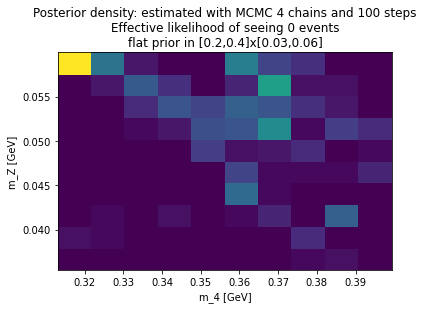

In [39]:
plt.hist2d(samples[:,0], samples[:,1], density=True)
plt.title('Posterior density: estimated with MCMC 4 chains and 100 steps\nEffective likelihood of seeing 0 events\nflat prior in [0.2,0.4]x[0.03,0.06]')
plt.xlabel('m_4 [GeV]')
plt.ylabel('m_Z [GeV]')
plt.savefig(f"{save_folder}density_Nwalkers_{nwalkers}_nstep_{nstep}_{selection_step}.png", bbox_inches='tight', dpi=250)

In [41]:
save_folder

'../../fig/kde_test_2d/mcmc_2d/'